# Set up environment

In [1]:
# convert jupyter to python
# !jupyter-nbconvert --to script gan_mlp_lstm_fx.ipynb

In [2]:
import os

# make only specific GPU to be utilized
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# select GPU to run on
GPU = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = GPU

# stop GPU
# os.environ["CUDA_VISIBLE_DEVICES"] ="-1"

# set GPU to be deterministic 
os.environ["PYTHONHASHSEED"] = "0" # set hash environment
os.environ["TF_CUDNN_USE_AUTOTUNE"] = "0" # use cuDNN function to retrieve the best algorithm
os.environ["TF_CUDNN_CONVOLUTION_BWD_FILTER_ALGO_DETERMINISTIC"]='1' # use cuDNN deterministic algorithms
os.environ['TF_DETERMINISTIC_OPS'] = '1' # deterministic setting

# set numpy, python, tensorflow random seed
from numpy.random import seed
import random
random.seed(10)
seed(10)
from tensorflow import set_random_seed
set_random_seed(20)

# control GPU memory usages
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.25
sess = tf.Session(config=config)

In [3]:
# check available GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
W0918 09:43:33.500793 140471978075968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0918 09:43:33.501996 140471978075968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0918 09:43:33.502644 140471978075968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0918 09:43:33.506089 140471978075968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
# check devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15123130380324847383
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2400931721226690287
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14382022964853724033
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4228513792
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13536034941566867151
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:05.0, compute capability: 7.0"
]


# Import modules

In [5]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# %matplotlib inline
plt.rcParams["font.size"] = 18
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import confusion_matrix

from keras.layers import Dense, Dropout, Input, Reshape, Bidirectional, Embedding
from keras.layers import LSTM, Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD, Adamax, RMSprop
from keras_ordered_neurons import ONLSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import CSVLogger, TensorBoard

from tqdm import tqdm, tqdm_notebook

# Import data

For data acquisition and pre-processing, see data_process_fx.ipynb 

In [6]:
# !ls 

## Get train data

In [7]:
# get train dataset
df_train = pd.read_csv("USDJPY/usdjpy_train.csv")
# df_train = pd.read_csv("USDJPY/usdjpy_train_2010-2017.csv")
# df_train = pd.read_csv("USDJPY/usdjpy_train_2015-2017.csv")

if "Date" in df_train.columns:
    df_train.sort_values("Date", inplace=True)
else:
    df_train.sort_values("datetime", inplace=True)   
df_train.head()
# df_train.dtypes

,datetime,Open
0,2018-01-02 10:00:00,112.37
1,2018-01-03 10:00:00,112.33
2,2018-01-04 10:00:00,112.61
3,2018-01-05 10:00:00,113.19
4,2018-01-08 10:00:00,113.22


## Get test data

In [8]:
# get test dataset
df_test0 = pd.read_csv("USDJPY/usdjpy_test.csv")
# df_test0 = pd.read_csv("USDJPY/usdjpy_test_2018-2019.csv")
# df_test0 = pd.read_csv("USDJPY/usdjpy_test_2018-2019.csv")

if "Date" in df_train.columns:
    df_test0.sort_values("Date", inplace=True)
else:
    df_test0.sort_values("datetime", inplace=True)
df_test0.head()

,datetime,Open
0,2019-01-01 10:00:00,109.59
1,2019-01-02 10:00:00,108.94
2,2019-01-03 10:00:00,107.63
3,2019-01-04 10:00:00,108.01
4,2019-01-07 10:00:00,108.19


## Convert price data to diff price data

In [9]:
# http://philipperemy.github.io/keras-stateful-lstm/

In [10]:
df_train["diff"] = np.where(df_train["Open"].diff()>=0, 1, -1) 
df_test0["diff"] = np.where(df_test0["Open"].diff()>=0, 1, -1) 
df_train.head()

,datetime,Open,diff
0,2018-01-02 10:00:00,112.37,-1
1,2018-01-03 10:00:00,112.33,-1
2,2018-01-04 10:00:00,112.61,1
3,2018-01-05 10:00:00,113.19,1
4,2018-01-08 10:00:00,113.22,1


# Set up parameter and process data shape

In [24]:
# set up parameters and features for training
batch_size = 60 #60
lstm_batch_size = 60 #60 #timestep
epochs = 200 #100
split_validate_test = 0.5
selected_features = ["Open"] # ["Open", "Vol"] # the first column should be the one would like to predict
# selected_features = ["diff"] # ["Open", "Vol"] # the first column should be the one would like to predict

In [25]:
# process train data
data_train = df_train[selected_features].values 
print ("data_train", data_train.shape)
benchmark_actual_train = df_train[selected_features].iloc[lstm_batch_size:].values
print ("benchmark_actual_train", benchmark_actual_train.shape)

# calculate number of features
num_features = data_train.shape[1]
print ("num_features", num_features)

# normalise data
scaler_train = MinMaxScaler(feature_range = (0, 1))
data_train_scaled = scaler_train.fit_transform(data_train)
scaler_train_output = MinMaxScaler(feature_range = (0, 1))
data_train_scaled_output = scaler_train_output.fit_transform(data_train[:,0:1])

# convert data shape for lstm
def convert_data_shape_for_lstm(data_scaled, lstm_batch_size):
    features0 = []
    labels0 = []
    for i in range(lstm_batch_size, len(data_scaled)):
        features0.append(data_scaled[i-lstm_batch_size:i, 0:data_scaled.shape[1]])
        labels0.append(data_scaled[i, 0])
    # reshape
    features0, labels0 = np.array(features0), np.array(labels0)
    features0 = np.reshape(features0, (features0.shape[0], features0.shape[1], data_scaled.shape[1]))
    print ("features", features0.shape)
    print ("labels", labels0.shape)
    return features0, labels0

train_features, train_labels = convert_data_shape_for_lstm(data_train_scaled, lstm_batch_size)

data_train (259, 1)
benchmark_actual_train (199, 1)
num_features 1
features (199, 60, 1)
labels (199,)


In [26]:
# process test data
data_total = pd.concat((df_train[selected_features], df_test0[selected_features]), axis=0)
print ("data_total", data_total.shape)
data_test = data_total[len(data_total) - len(df_test0) - lstm_batch_size + 1:].values
print ("data_test", data_test.shape)

# normalise data
scaler_test = MinMaxScaler(feature_range = (0, 1))
data_test_scaled = scaler_train.fit_transform(data_test)

# convert data shape for lstm
test_features0, test_labels0 = convert_data_shape_for_lstm(data_test_scaled, lstm_batch_size)

# seperate validate and test
validate_features = test_features0[0:int(len(test_features0)*split_validate_test)]
test_features = test_features0[int(len(test_features0)*split_validate_test):]
validate_labels = test_labels0[0:int(len(test_labels0)*split_validate_test)]
test_labels = test_labels0[int(len(test_labels0)*split_validate_test):]

benchmark_actual_test = data_test[int((len(test_features0))*split_validate_test)+lstm_batch_size:,]

print ("test_features", test_features.shape)
print ("validate_features", validate_features.shape)
print ("benchmark_actual_test", benchmark_actual_test.shape)

data_total (411, 1)
data_test (211, 1)
features (151, 60, 1)
labels (151,)
test_features (76, 60, 1)
validate_features (75, 60, 1)
benchmark_actual_test (76, 1)


In [13]:
def plot_timeseries(epoch, training_type, discriminator_type, generator_type, generated_timeseries, real_data, examples=100):
    plt.figure(figsize=(8,5))
    for i in range(generated_timeseries.T.shape[0]):
        plt.rcParams["font.size"] = 18
        ax1 = plt.subplot(1, 1, i+1)
        ax1.plot(generated_timeseries.T[0], color='r', label='predict', linewidth=3.0)
        ax1.ticklabel_format(useOffset=False)
        ax2 = ax1.twinx()
        ax2.plot(real_data, color='b', label="real", linewidth=3.0)
        ax2.ticklabel_format(useOffset=False)
        plt.ylim([105,119])
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.xlabel("Day")
        plt.ylabel("Price")        
        ax1.legend()
        ax1.set_title('USDJPY: Epoch={}'.format(epoch), fontsize=20)
    plt.tight_layout()
    plt.savefig('output/%s_%s_%s_generated_timeseries_%d.png' %(training_type, discriminator_type, generator_type, epoch))
    #plt.close()
    
def plot_timeseries2(epoch, training_type, discriminator_type, generator_type, generated_timeseries, real_data, examples=100):
    print (len(generated_timeseries.T[0]), len(real_data))
    plt.figure(figsize=(8,5))
    for i in range(generated_timeseries.T.shape[0]):
        plt.rcParams["font.size"] = 18
        ax1 = plt.subplot(1, 1, i+1)
        ax1.plot(generated_timeseries.T[0], color='r', label='predict', linewidth=3.0)
        ax1.ticklabel_format(useOffset=False)
        ax1.plot(real_data, color='b', label="real", linewidth=3.0)
        ax1.ticklabel_format(useOffset=False)
        plt.xlabel("Day")
        plt.ylabel("Price (USDJPY)")        
        ax1.legend()
        ax1.set_title('{}_{}_{}'.format(training_type, discriminator_type, generator_type), fontsize=20)
    plt.tight_layout()
    plt.savefig('output/%s_%s_%s_generated_timeseries_%d.png' %(training_type, discriminator_type, generator_type, epoch))
    #plt.close()    

# ARIMA

In [14]:
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [15]:
# # fit model
# arima_model = ARIMA(data_train, order=(5,1,0))
# arima_model_fit = arima_model.fit(disp=0)
# print(arima_model_fit.summary())

In [16]:
# # plot residual errors
# residuals = pd.DataFrame(arima_model_fit.resid)
# residuals.plot()
# plt.show()
# residuals.plot(kind='kde')
# plt.show()
# print(residuals.describe())

In [17]:
# train_arima = data_total[0:data_train.shape[0]].values[:,0]
# test_arima = data_total[data_train.shape[0]:data_total.shape[0]].values[:,0]
# print (train_arima.shape, test_arima.shape)
# history = [x for x in train_arima]
# arima_predictions = list()
# for t in range(len(test_arima)):
#     arima_model = ARIMA(history, order=(5,1,0))
#     arima_model_fit = arima_model.fit(disp=0)
#     output = arima_model_fit.forecast()
#     yhat = output[0]
#     arima_predictions.append(yhat)
#     obs = test_arima[t]
#     history.append(obs)
#     # print('predicted=%f, expected=%f' % (yhat, obs))
# error = mean_squared_error(test_arima, arima_predictions)
# print('Test MSE: %.3f' % error)
# # plot
# plt.plot(test_arima)
# plt.plot(arima_predictions, color='red')
# plt.show()

# LSTM

In [18]:
# https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/

In [19]:
# lstm_model
def create_lstm_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=500, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
    lstm_model.add(Dropout(0.01))
    lstm_model.add(LSTM(units=500, return_sequences=True))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(LSTM(units=500, return_sequences=True))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(LSTM(units=500))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(Dense(units = 1))

    lstm_model.compile(optimizer = 'RMSprop', 
                       loss = 'mean_squared_error', metrics=['accuracy'])

    return lstm_model
lstm_model = create_lstm_model()
# lstm_model.summary()

W0918 07:47:14.569934 140277097690944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0918 07:47:15.151640 140277097690944 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0918 07:47:16.767248 140277097690944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [20]:
# lstm_history = lstm_model.fit(train_features, train_labels, epochs = epochs, batch_size = batch_size)
# tb_cb =TensorBoard(log_dir="tflog/", histogram_freq=1)
# cbks = [tb_cb]
# lstm_history = lstm_model.fit(train_features, train_labels, epochs = epochs, batch_size = batch_size,
#                               validation_data=(validate_features, validate_labels),
#                               callbacks=cbks)
# lstm_history = lstm_model.fit(train_features, train_labels, epochs=100, batch_size=32, verbose=1, shuffle=False,
#                               callbacks=[ReduceLROnPlateau(factor=0.67, patience=3, verbose=1, min_lr=1E-5),
#                                          EarlyStopping(patience=200, verbose=1)])

print (train_features.shape, train_labels.shape)
lstm_history = lstm_model.fit(train_features, train_labels, epochs = epochs, batch_size = batch_size,
                              validation_data=(validate_features, validate_labels),
                              shuffle=False)

lstm_score, lstm_acc = lstm_model.evaluate(test_features, test_labels, batch_size=batch_size, verbose=0)
print (lstm_score, lstm_acc)

(199, 60, 1) (199,)


W0918 07:47:17.016659 140277097690944 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 199 samples, validate on 75 samples
Epoch 1/200
199/199 [==============================] - 6s 28ms/step - loss: 2.7128 - acc: 0.0000e+00 - val_loss: 0.2777 - val_acc: 0.0000e+00
Epoch 2/200
199/199 [==============================] - 2s 8ms/step - loss: 0.4133 - acc: 0.0000e+00 - val_loss: 0.0532 - val_acc: 0.0000e+00
Epoch 3/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0592 - acc: 0.0050 - val_loss: 0.0316 - val_acc: 0.0000e+00
Epoch 4/200
199/199 [==============================] - 1s 8ms/step - loss: 0.0174 - acc: 0.0050 - val_loss: 0.0421 - val_acc: 0.0000e+00
Epoch 5/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0251 - acc: 0.0050 - val_loss: 0.0323 - val_acc: 0.0000e+00
Epoch 6/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0176 - acc: 0.0050 - val_loss: 0.0475 - val_acc: 0.0000e+00
Epoch 7/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0293 - acc: 0.0050 - val_loss: 0.1176 - val_acc

Epoch 60/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0294 - acc: 0.0050 - val_loss: 0.0287 - val_acc: 0.0000e+00
Epoch 61/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0218 - acc: 0.0050 - val_loss: 0.0235 - val_acc: 0.0000e+00
Epoch 62/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0142 - acc: 0.0050 - val_loss: 0.0165 - val_acc: 0.0000e+00
Epoch 63/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0273 - acc: 0.0050 - val_loss: 0.0207 - val_acc: 0.0000e+00
Epoch 64/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0319 - acc: 0.0050 - val_loss: 0.0212 - val_acc: 0.0000e+00
Epoch 65/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0269 - acc: 0.0050 - val_loss: 0.0396 - val_acc: 0.0000e+00
Epoch 66/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0228 - acc: 0.0050 - val_loss: 0.0202 - val_acc: 0.0000e+00
Epoch 67/200
199/199 [============

199/199 [==============================] - 2s 8ms/step - loss: 0.0096 - acc: 0.0050 - val_loss: 0.0129 - val_acc: 0.0000e+00
Epoch 120/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0087 - acc: 0.0050 - val_loss: 0.0198 - val_acc: 0.0000e+00
Epoch 121/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0089 - acc: 0.0050 - val_loss: 0.0139 - val_acc: 0.0000e+00
Epoch 122/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0080 - acc: 0.0050 - val_loss: 0.0147 - val_acc: 0.0000e+00
Epoch 123/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0078 - acc: 0.0050 - val_loss: 0.0091 - val_acc: 0.0000e+00
Epoch 124/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0063 - acc: 0.0050 - val_loss: 0.0089 - val_acc: 0.0000e+00
Epoch 125/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0053 - acc: 0.0050 - val_loss: 0.0069 - val_acc: 0.0000e+00
Epoch 126/200
199/199 [==================

199/199 [==============================] - 2s 8ms/step - loss: 0.0047 - acc: 0.0050 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 179/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0032 - acc: 0.0050 - val_loss: 0.0041 - val_acc: 0.0000e+00
Epoch 180/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0037 - acc: 0.0050 - val_loss: 0.0094 - val_acc: 0.0000e+00
Epoch 181/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0072 - acc: 0.0050 - val_loss: 0.0044 - val_acc: 0.0000e+00
Epoch 182/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0055 - acc: 0.0050 - val_loss: 0.0041 - val_acc: 0.0000e+00
Epoch 183/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0033 - acc: 0.0050 - val_loss: 0.0047 - val_acc: 0.0000e+00
Epoch 184/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0039 - acc: 0.0050 - val_loss: 0.0092 - val_acc: 0.0000e+00
Epoch 185/200
199/199 [==================

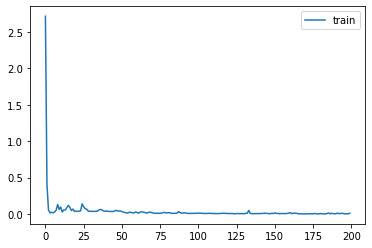

In [21]:
# plot history
plt.plot(lstm_history.history['loss'], label='train')
plt.legend()
plt.show()

(199, 1) (199, 60, 1)
199 199


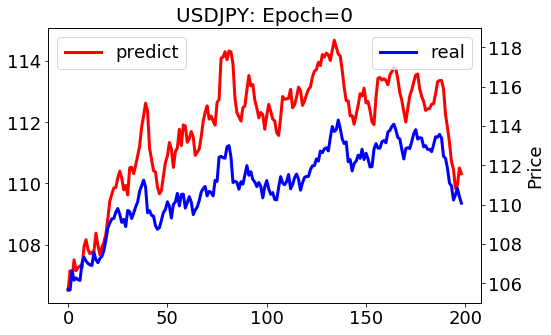

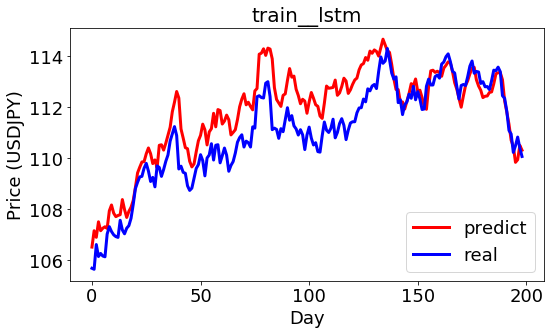

In [22]:
train_lstm_predict = lstm_model.predict(train_features)
print (train_lstm_predict.shape, train_features.shape)
train_lstm_predict = scaler_train_output.inverse_transform(train_lstm_predict)
plot_timeseries(0, "train", "", "lstm", train_lstm_predict, benchmark_actual_train)
plot_timeseries2(0, "train", "", "lstm", train_lstm_predict, benchmark_actual_train)

## prediction

76 76


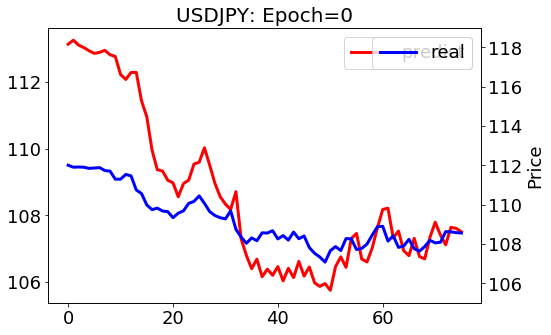

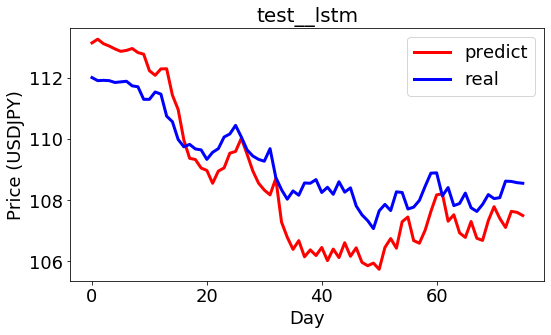

In [23]:
lstm_predictions = lstm_model.predict(test_features)
lstm_predictions = scaler_train_output.inverse_transform(lstm_predictions)
plot_timeseries(0, "test", "", "lstm", lstm_predictions, benchmark_actual_test)
plot_timeseries2(0, "test", "", "lstm", lstm_predictions, benchmark_actual_test)

In [24]:
actual = benchmark_actual_test
y_true = np.where(np.diff(actual.T[0])>=0, 1, -1) 
y_pred = np.where(np.diff(lstm_predictions[:,0])>=0, 1, -1) 
confusion_matrix(y_true, y_pred)

array([[21, 21],
       [23, 10]])

# Ordered-neurons LSTM

In [25]:
# https://arxiv.org/abs/1810.09536
# https://github.com/CyberZHG/keras-ordered-neurons/blob/master/README.md

In [26]:
# lstm_model
def create_on_lstm_model():
    on_lstm_model = Sequential()
    on_lstm_model.add(ONLSTM(units=500, chunk_size=5, return_sequences=True, 
                                        input_shape=(train_features.shape[1], train_features.shape[2])))
    on_lstm_model.add(Dropout(0.01))
    on_lstm_model.add(ONLSTM(units=500, chunk_size=5, return_sequences=True))
    on_lstm_model.add(Dropout(0.01))

    on_lstm_model.add(ONLSTM(units=500, chunk_size=5, return_sequences=True))
    on_lstm_model.add(Dropout(0.01))

    on_lstm_model.add(ONLSTM(units=500, chunk_size=5))
    on_lstm_model.add(Dropout(0.01))

    on_lstm_model.add(Dense(units = 1))

    on_lstm_model.compile(optimizer = 'RMSprop', 
                       loss = 'mean_squared_error', metrics=['accuracy'])
    
    return on_lstm_model
on_lstm_model = create_on_lstm_model()
on_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
onlstm_1 (ONLSTM)            (None, 60, 500)           1104400   
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 500)           0         
_________________________________________________________________
onlstm_2 (ONLSTM)            (None, 60, 500)           2202200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 500)           0         
_________________________________________________________________
onlstm_3 (ONLSTM)            (None, 60, 500)           2202200   
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 500)           0         
_________________________________________________________________
onlstm_4 (ONLSTM)            (None, 500)              

In [27]:
# on_lstm_history = on_lstm_model.fit(train_features, train_labels, epochs = epochs, batch_size = batch_size)
on_lstm_history = on_lstm_model.fit(train_features, train_labels, 
                                    epochs = epochs, batch_size = batch_size,
                                    validation_data=(validate_features, validate_labels),
                                    shuffle=False)
on_lstm_score, on_lstm_acc = on_lstm_model.evaluate(test_features, test_labels, 
                                                    batch_size=batch_size, verbose=0)
print (on_lstm_score, on_lstm_acc)

Train on 199 samples, validate on 75 samples
Epoch 1/200
199/199 [==============================] - 8s 41ms/step - loss: 0.3815 - acc: 0.0000e+00 - val_loss: 0.1938 - val_acc: 0.0000e+00
Epoch 2/200
199/199 [==============================] - 3s 17ms/step - loss: 0.3535 - acc: 0.0000e+00 - val_loss: 0.0512 - val_acc: 0.0000e+00
Epoch 3/200
199/199 [==============================] - 3s 17ms/step - loss: 0.3988 - acc: 0.0000e+00 - val_loss: 0.1497 - val_acc: 0.0000e+00
Epoch 4/200
199/199 [==============================] - 3s 17ms/step - loss: 0.3124 - acc: 0.0000e+00 - val_loss: 0.1155 - val_acc: 0.0000e+00
Epoch 5/200
199/199 [==============================] - 3s 17ms/step - loss: 0.2508 - acc: 0.0000e+00 - val_loss: 0.0687 - val_acc: 0.0000e+00
Epoch 6/200
199/199 [==============================] - 3s 16ms/step - loss: 0.1473 - acc: 0.0000e+00 - val_loss: 0.0265 - val_acc: 0.0000e+00
Epoch 7/200
199/199 [==============================] - 3s 16ms/step - loss: 0.0317 - acc: 0.0050 - val_

199/199 [==============================] - 3s 16ms/step - loss: 0.0092 - acc: 0.0050 - val_loss: 0.0065 - val_acc: 0.0000e+00
Epoch 60/200
199/199 [==============================] - 3s 17ms/step - loss: 0.0105 - acc: 0.0050 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 61/200
199/199 [==============================] - 3s 16ms/step - loss: 0.0125 - acc: 0.0050 - val_loss: 0.0170 - val_acc: 0.0000e+00
Epoch 62/200
199/199 [==============================] - 3s 16ms/step - loss: 0.0158 - acc: 0.0050 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 63/200
199/199 [==============================] - 3s 17ms/step - loss: 0.0095 - acc: 0.0050 - val_loss: 0.0082 - val_acc: 0.0000e+00
Epoch 64/200
199/199 [==============================] - 3s 16ms/step - loss: 0.0113 - acc: 0.0050 - val_loss: 0.0135 - val_acc: 0.0000e+00
Epoch 65/200
199/199 [==============================] - 3s 16ms/step - loss: 0.0100 - acc: 0.0050 - val_loss: 0.0085 - val_acc: 0.0000e+00
Epoch 66/200
199/199 [==================

Epoch 118/200
199/199 [==============================] - 3s 16ms/step - loss: 0.0082 - acc: 0.0050 - val_loss: 0.0077 - val_acc: 0.0000e+00
Epoch 119/200
199/199 [==============================] - 3s 16ms/step - loss: 0.0057 - acc: 0.0050 - val_loss: 0.0068 - val_acc: 0.0000e+00
Epoch 120/200
199/199 [==============================] - 3s 17ms/step - loss: 0.0065 - acc: 0.0050 - val_loss: 0.0064 - val_acc: 0.0000e+00
Epoch 121/200
199/199 [==============================] - 3s 16ms/step - loss: 0.0059 - acc: 0.0050 - val_loss: 0.0099 - val_acc: 0.0000e+00
Epoch 122/200
199/199 [==============================] - 3s 16ms/step - loss: 0.0096 - acc: 0.0050 - val_loss: 0.0159 - val_acc: 0.0000e+00
Epoch 123/200
199/199 [==============================] - 3s 17ms/step - loss: 0.0115 - acc: 0.0050 - val_loss: 0.0068 - val_acc: 0.0000e+00
Epoch 124/200
199/199 [==============================] - 3s 18ms/step - loss: 0.0069 - acc: 0.0050 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 125/200
199/19

199/199 [==============================] - 3s 16ms/step - loss: 0.0097 - acc: 0.0050 - val_loss: 0.0061 - val_acc: 0.0000e+00
Epoch 177/200
199/199 [==============================] - 3s 16ms/step - loss: 0.0052 - acc: 0.0050 - val_loss: 0.0065 - val_acc: 0.0000e+00
Epoch 178/200
199/199 [==============================] - 3s 16ms/step - loss: 0.0096 - acc: 0.0050 - val_loss: 0.0079 - val_acc: 0.0000e+00
Epoch 179/200
199/199 [==============================] - 3s 17ms/step - loss: 0.0060 - acc: 0.0050 - val_loss: 0.0077 - val_acc: 0.0000e+00
Epoch 180/200
199/199 [==============================] - 3s 16ms/step - loss: 0.0105 - acc: 0.0050 - val_loss: 0.0073 - val_acc: 0.0000e+00
Epoch 181/200
199/199 [==============================] - 3s 17ms/step - loss: 0.0069 - acc: 0.0050 - val_loss: 0.0095 - val_acc: 0.0000e+00
Epoch 182/200
199/199 [==============================] - 3s 17ms/step - loss: 0.0112 - acc: 0.0050 - val_loss: 0.0065 - val_acc: 0.0000e+00
Epoch 183/200
199/199 [===========

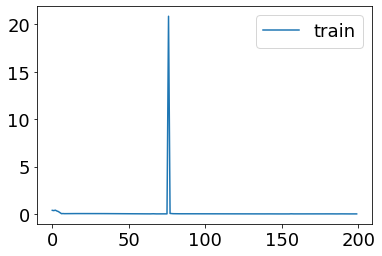

In [28]:
# plot history
plt.plot(on_lstm_history.history['loss'], label='train')
plt.legend()
plt.show()

(199, 1) (199, 60, 1)
199 199


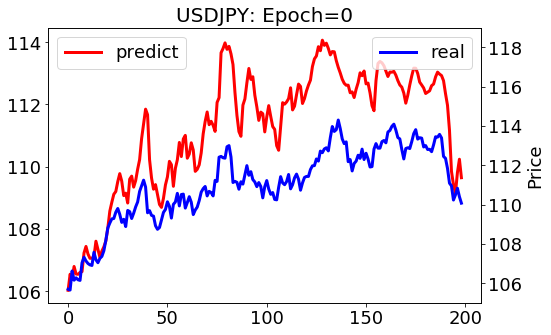

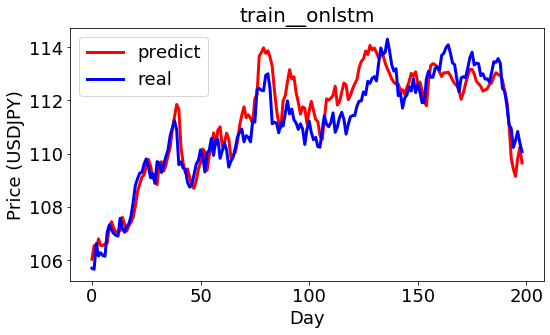

In [29]:
train_on_lstm_predict = on_lstm_model.predict(train_features)
print (train_on_lstm_predict.shape, train_features.shape)
train_on_lstm_predict = scaler_train_output.inverse_transform(train_on_lstm_predict)
plot_timeseries(0, "train", "", "onlstm", train_on_lstm_predict, benchmark_actual_train)
plot_timeseries2(0, "train", "", "onlstm", train_on_lstm_predict, benchmark_actual_train)

76 76
76 76


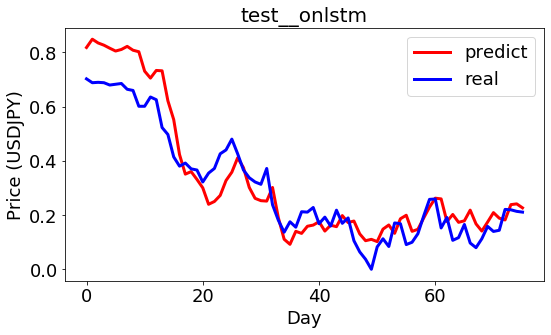

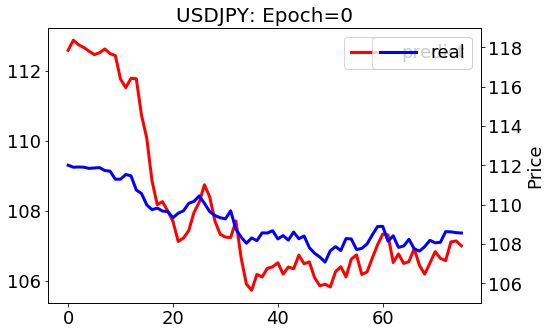

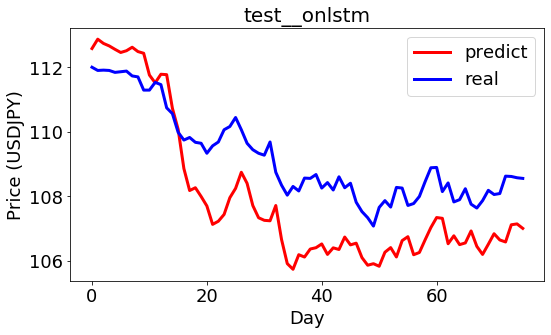

In [30]:
on_lstm_predictions = on_lstm_model.predict(test_features)
plot_timeseries2(0, "test", "", "onlstm", on_lstm_predictions, 
                 data_test_scaled[int(lstm_batch_size+len(test_features0)*split_validate_test):])
on_lstm_predictions = scaler_train_output.inverse_transform(on_lstm_predictions)
plot_timeseries(0, "test", "", "onlstm", on_lstm_predictions, benchmark_actual_test)
plot_timeseries2(0, "test", "", "onlstm", on_lstm_predictions, benchmark_actual_test)

In [31]:
actual = benchmark_actual_test
y_true = np.where(np.diff(actual.T[0])>=0, 1, -1) 
y_pred = np.where(np.diff(on_lstm_predictions[:,0])>=0, 1, -1) 
confusion_matrix(y_true, y_pred)

array([[21, 21],
       [20, 13]])

# GAN

In [32]:
# https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3
# https://qiita.com/taku-buntu/items/0093a68bfae0b0ff879d
# https://qiita.com/yoyoyo_/items/56c6fcbd5a853460f506

## Generator and Discriminator

In [33]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=128, input_dim=1))
    generator.add(LeakyReLU(0.2))
    generator.add(Dropout(0.3))           
    generator.add(Dense(units=64))
    generator.add(LeakyReLU(0.2))
    generator.add(Dropout(0.3))       
    generator.add(Dense(units=32))
    generator.add(LeakyReLU(0.2))    
    generator.add(Dense(units=1, activation='sigmoid'))    
    generator.compile(loss='mean_squared_error', 
                          optimizer='RMSprop')
    return generator
g=create_generator()
g.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)               

In [34]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=512,input_dim=1))
    discriminator.add(LeakyReLU(alpha=0.1))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(alpha=0.1))
    discriminator.add(Dense(128))
    discriminator.add(LeakyReLU(alpha=0.1))
#     discriminator.add(Dense(64))
#     discriminator.add(LeakyReLU(alpha=0.1))
    discriminator.add(Dense(units=1, activation='sigmoid'))    
    
#     discriminator.compile(loss='binary_crossentropy', optimizer='adam')
    discriminator.compile(loss='binary_crossentropy', optimizer='RMSprop')
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               1024      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

In [35]:
def create_gan(discriminator, generator, generator_type="lstm"):
    discriminator.trainable=False

    if generator_type=="mlp":
        gan_input = Input(shape=(num_features,))
    else:
        gan_input = Input(shape=(lstm_batch_size, num_features))
    print (gan_input.shape)
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
#     gan.compile(loss='binary_crossentropy', optimizer='RMSprop')
                          
    return gan
# gan = create_gan(d,g)
# gan.summary()

# Training

In [36]:
def training(epochs=1, batch_size=60, discriminator_type="gan", generator_type="lstm"):

    #Loading the data
    batch_count = int(train_features.shape[0] / batch_size)
    print ("batch_count", batch_count)
    print ("batch_size", batch_size)
    print ("lstm_batch_size", lstm_batch_size)
    
    # Creating GAN generator
    if generator_type == "lstm":
        generator = create_lstm_model()
    elif generator_type == "on_lstm":
        generator = create_on_lstm_model()
    elif generator_type == "mlp":
        generator = create_generator()
       
    # Creating GAN discriminator
    if discriminator_type == "gan":
        discriminator = create_discriminator()
    elif discriminator_type == "wgan":
        discriminator = create_wgan_discriminator()

    # Creating GAN 
    gan = create_gan(discriminator, generator, generator_type)

    # Set up label for valid and fake conditions
    valid = np.ones((batch_size, 1)) * 1.0 # prevent overconfidence by penalising the discriminator (1=>0.9)
    # valid = np.ones((batch_size, 1)) * 0.9 # prevent overconfidence by penalising the discriminator (1=>0.9)
    fake = np.zeros((batch_size, 1))    
    actual_data_train_all = data_train_scaled[lstm_batch_size:,0]
    losses = []
    
    for epoch in range(1,epochs+1 ):
        for i in range(batch_count):
            
            # Generate fake time-series from lstm model input
            if generator_type == "mlp":
                noise = np.random.uniform(-1, 1, (batch_size, num_features))
                generated_timeseries = generator.predict(noise)               
            else:
                train_timeseries_batch = train_features[batch_size*i:batch_size*(i+1),:,:]
                generated_timeseries = generator.predict(train_timeseries_batch) 

            # Train the discriminator (real classified as ones and generated as zeros)
            actual_data_train = actual_data_train_all[batch_size*i:batch_size*(i+1)]
            discriminator.trainable=True
            
            #Construct different batches of  real and fake data 
            X = np.concatenate([actual_data_train, generated_timeseries[:,0]])
            y = np.concatenate([valid, fake])
            d_loss = discriminator.train_on_batch(X, y)
            discriminator.trainable=False
            
            # Train Generator: combined model  (stacked generator and discriminator)
            # Train the generator (wants discriminator to mistake images as real)  
            if generator_type == "mlp":
                noise = np.random.uniform(-1, 1, (batch_size, num_features))
                g_loss = gan.train_on_batch(noise, valid)
            else:
                g_loss = gan.train_on_batch(train_timeseries_batch, valid)

            # Print out losses
            print ("Epoch: %d, Batch_count: %d, [D loss: %f] [G loss: %f]" % (epoch, batch_count, d_loss, g_loss))
            losses.append([epoch, d_loss, g_loss])
        
        if epoch == 1 or epoch % 100 == 0:
            if generator_type == "mlp":
                noise_train = np.random.uniform(-1, 1, (train_features.shape[0], num_features))
                generated_timeseries_predict_train = generator.predict(noise_train)
                noise_test = np.random.uniform(-1, 1, (test_features.shape[0], num_features))
                generated_timeseries_predict_test = generator.predict(noise_test)
            else:
                generated_timeseries_predict_train = generator.predict(train_features)
                generated_timeseries_predict_test = generator.predict(test_features)
            
            # Inverse transform using train fit_transform model for both train and test sets
            train_predictions = scaler_train_output.inverse_transform(generated_timeseries_predict_train)
            test_predictions = scaler_train_output.inverse_transform(generated_timeseries_predict_test)
            
            # Plot train and test
            plot_timeseries(epoch, "train", discriminator_type, generator_type, train_predictions, benchmark_actual_train)
            plot_timeseries(epoch, "test", discriminator_type, generator_type, test_predictions, benchmark_actual_test)
            plot_timeseries2(epoch, "train", discriminator_type, generator_type, train_predictions, benchmark_actual_train)
            plot_timeseries2(epoch, "test", discriminator_type, generator_type, test_predictions, benchmark_actual_test)
            
            # Save model
            generator.save('train_model/generator_model_' + str(discriminator_type) + '_' + str(generator_type) + '_' + str(epoch) + '.h5')
            gan.save('train_model/gan_model_' + str(discriminator_type) + '_' + str(generator_type) + '_' + str(epoch) + '.h5')
    return test_predictions, losses, generator

# GAN

In [37]:
# gan_predictions, gan_losses, gan_generator = training(epochs, batch_size, "gan", "mlp")

In [38]:
# plt.plot(np.transpose(gan_losses)[0], np.transpose(gan_losses)[1], label='d_loss')
# plt.plot(np.transpose(gan_losses)[0], np.transpose(gan_losses)[2], label='g_loss')
# plt.legend()

# GAN + LSTM

In [39]:
# epochs = 100
# gan_lstm_predictions, gan_lstm_losses, gan_lstm_generator = training(epochs, batch_size, "gan", "lstm")

In [40]:
# plt.plot(np.transpose(gan_lstm_losses)[0], np.transpose(gan_lstm_losses)[1], label='d_loss')
# plt.plot(np.transpose(gan_lstm_losses)[0], np.transpose(gan_lstm_losses)[2], label='g_loss')
# plt.legend()

# GAN + ON-LSTM

batch_count 3
batch_size 60
lstm_batch_size 60
(?, 60, 1)
Epoch: 1, Batch_count: 3, [D loss: 0.692335] [G loss: 0.695406]
Epoch: 1, Batch_count: 3, [D loss: 0.627265] [G loss: 0.729158]
Epoch: 1, Batch_count: 3, [D loss: 0.521379] [G loss: 0.766562]
199 199
76 76
Epoch: 2, Batch_count: 3, [D loss: 0.543241] [G loss: 0.812276]
Epoch: 2, Batch_count: 3, [D loss: 0.482404] [G loss: 0.838714]
Epoch: 2, Batch_count: 3, [D loss: 0.544603] [G loss: 0.762170]
Epoch: 3, Batch_count: 3, [D loss: 0.799414] [G loss: 0.848516]
Epoch: 3, Batch_count: 3, [D loss: 1.131810] [G loss: 3.823931]
Epoch: 3, Batch_count: 3, [D loss: 0.835916] [G loss: 1.582363]
Epoch: 4, Batch_count: 3, [D loss: 0.724204] [G loss: 1.026859]
Epoch: 4, Batch_count: 3, [D loss: 0.780710] [G loss: 0.927091]
Epoch: 4, Batch_count: 3, [D loss: 0.781556] [G loss: 0.867177]
Epoch: 5, Batch_count: 3, [D loss: 0.709503] [G loss: 0.844051]
Epoch: 5, Batch_count: 3, [D loss: 0.686727] [G loss: 0.848378]
Epoch: 5, Batch_count: 3, [D los

Epoch: 43, Batch_count: 3, [D loss: 0.663706] [G loss: 0.937459]
Epoch: 43, Batch_count: 3, [D loss: 0.392173] [G loss: 1.121213]
Epoch: 43, Batch_count: 3, [D loss: 0.232990] [G loss: 1.419066]
Epoch: 44, Batch_count: 3, [D loss: 0.684082] [G loss: 0.973982]
Epoch: 44, Batch_count: 3, [D loss: 0.325901] [G loss: 1.159553]
Epoch: 44, Batch_count: 3, [D loss: 0.216128] [G loss: 1.413745]
Epoch: 45, Batch_count: 3, [D loss: 0.733266] [G loss: 0.933162]
Epoch: 45, Batch_count: 3, [D loss: 0.348593] [G loss: 1.142841]
Epoch: 45, Batch_count: 3, [D loss: 0.243034] [G loss: 1.356449]
Epoch: 46, Batch_count: 3, [D loss: 0.871394] [G loss: 0.882728]
Epoch: 46, Batch_count: 3, [D loss: 0.573259] [G loss: 1.152503]
Epoch: 46, Batch_count: 3, [D loss: 0.347146] [G loss: 1.174531]
Epoch: 47, Batch_count: 3, [D loss: 1.204447] [G loss: 1.235031]
Epoch: 47, Batch_count: 3, [D loss: 0.963542] [G loss: 1.122233]
Epoch: 47, Batch_count: 3, [D loss: 0.974563] [G loss: 1.372015]
Epoch: 48, Batch_count: 3

Epoch: 85, Batch_count: 3, [D loss: 0.738527] [G loss: 0.740676]
Epoch: 85, Batch_count: 3, [D loss: 0.753468] [G loss: 0.757684]
Epoch: 86, Batch_count: 3, [D loss: 0.682150] [G loss: 0.712724]
Epoch: 86, Batch_count: 3, [D loss: 0.729483] [G loss: 0.739347]
Epoch: 86, Batch_count: 3, [D loss: 0.724202] [G loss: 0.763810]
Epoch: 87, Batch_count: 3, [D loss: 0.687855] [G loss: 0.715354]
Epoch: 87, Batch_count: 3, [D loss: 0.717340] [G loss: 0.760928]
Epoch: 87, Batch_count: 3, [D loss: 0.681012] [G loss: 0.767468]
Epoch: 88, Batch_count: 3, [D loss: 0.690296] [G loss: 0.717265]
Epoch: 88, Batch_count: 3, [D loss: 0.689327] [G loss: 0.742105]
Epoch: 88, Batch_count: 3, [D loss: 0.556254] [G loss: 0.710767]
Epoch: 89, Batch_count: 3, [D loss: 0.680368] [G loss: 0.694867]
Epoch: 89, Batch_count: 3, [D loss: 0.597103] [G loss: 0.772099]
Epoch: 89, Batch_count: 3, [D loss: 0.359530] [G loss: 0.952662]
Epoch: 90, Batch_count: 3, [D loss: 0.697999] [G loss: 0.833340]
Epoch: 90, Batch_count: 3

Epoch: 127, Batch_count: 3, [D loss: 1.023107] [G loss: 0.829620]
Epoch: 127, Batch_count: 3, [D loss: 1.108333] [G loss: 0.876539]
Epoch: 127, Batch_count: 3, [D loss: 0.712839] [G loss: 1.909884]
Epoch: 128, Batch_count: 3, [D loss: 0.862748] [G loss: 2.080002]
Epoch: 128, Batch_count: 3, [D loss: 0.784650] [G loss: 1.254042]
Epoch: 128, Batch_count: 3, [D loss: 1.015861] [G loss: 1.047446]
Epoch: 129, Batch_count: 3, [D loss: 0.803096] [G loss: 1.114602]
Epoch: 129, Batch_count: 3, [D loss: 0.660812] [G loss: 1.148036]
Epoch: 129, Batch_count: 3, [D loss: 0.572129] [G loss: 1.171651]
Epoch: 130, Batch_count: 3, [D loss: 0.734137] [G loss: 1.125708]
Epoch: 130, Batch_count: 3, [D loss: 0.614111] [G loss: 1.119783]
Epoch: 130, Batch_count: 3, [D loss: 0.469526] [G loss: 1.126044]
Epoch: 131, Batch_count: 3, [D loss: 0.699665] [G loss: 1.074760]
Epoch: 131, Batch_count: 3, [D loss: 0.568359] [G loss: 1.074869]
Epoch: 131, Batch_count: 3, [D loss: 0.362328] [G loss: 1.112013]
Epoch: 132

Epoch: 168, Batch_count: 3, [D loss: 0.686560] [G loss: 0.784080]
Epoch: 169, Batch_count: 3, [D loss: 0.694121] [G loss: 0.776127]
Epoch: 169, Batch_count: 3, [D loss: 0.683026] [G loss: 0.796836]
Epoch: 169, Batch_count: 3, [D loss: 0.663539] [G loss: 0.838062]
Epoch: 170, Batch_count: 3, [D loss: 0.692082] [G loss: 0.817501]
Epoch: 170, Batch_count: 3, [D loss: 0.669583] [G loss: 0.837349]
Epoch: 170, Batch_count: 3, [D loss: 0.639405] [G loss: 0.882608]
Epoch: 171, Batch_count: 3, [D loss: 0.688928] [G loss: 0.849685]
Epoch: 171, Batch_count: 3, [D loss: 0.653678] [G loss: 0.869843]
Epoch: 171, Batch_count: 3, [D loss: 0.606332] [G loss: 0.888453]
Epoch: 172, Batch_count: 3, [D loss: 0.678932] [G loss: 0.856804]
Epoch: 172, Batch_count: 3, [D loss: 0.628978] [G loss: 0.879603]
Epoch: 172, Batch_count: 3, [D loss: 0.491556] [G loss: 0.847984]
Epoch: 173, Batch_count: 3, [D loss: 0.659522] [G loss: 0.836374]
Epoch: 173, Batch_count: 3, [D loss: 0.552626] [G loss: 0.803253]
Epoch: 173

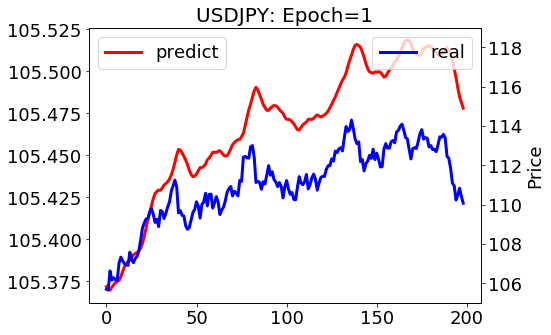

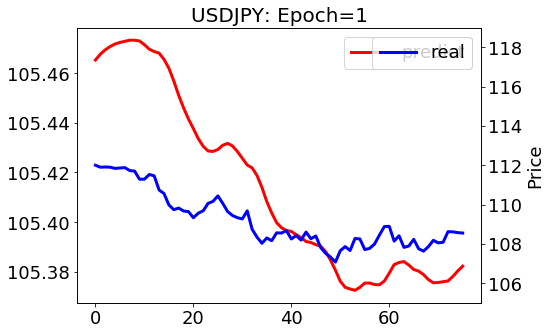

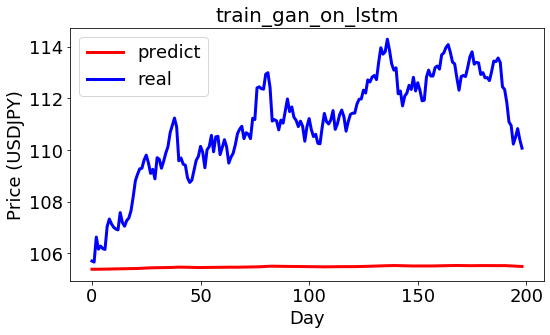

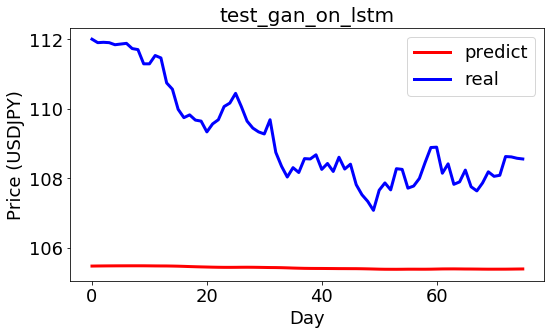

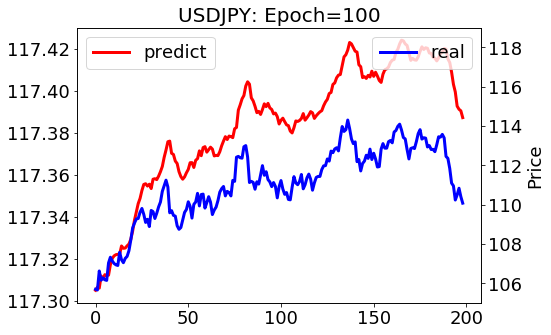

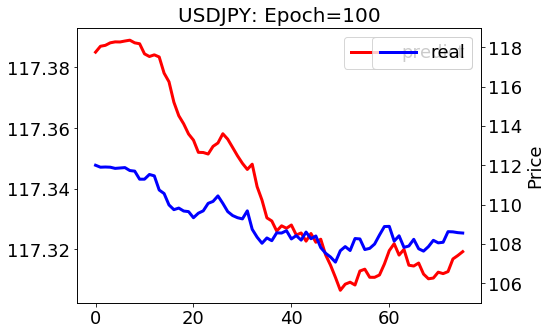

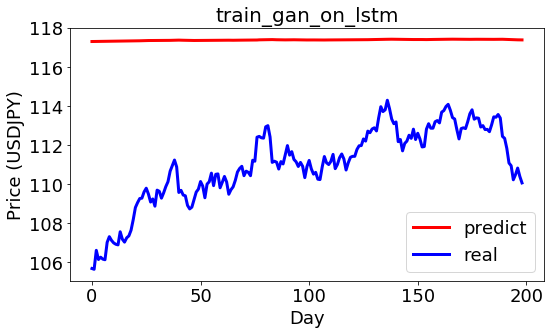

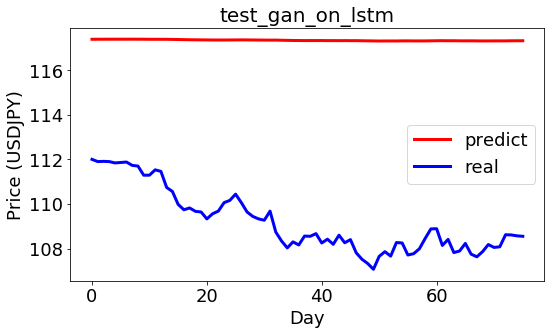

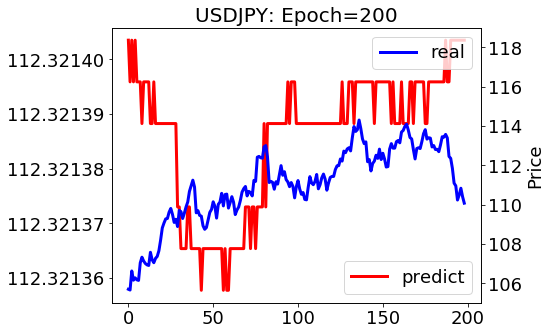

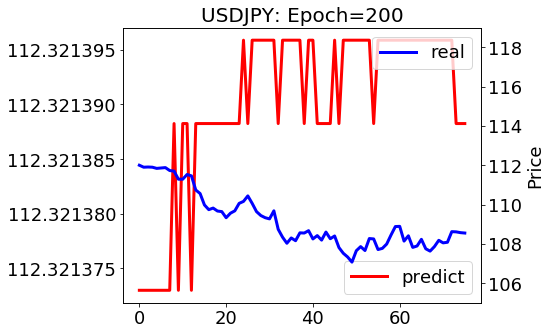

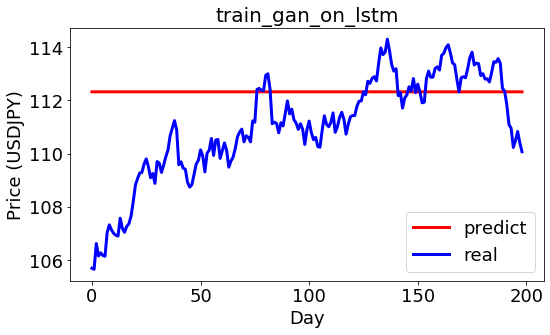

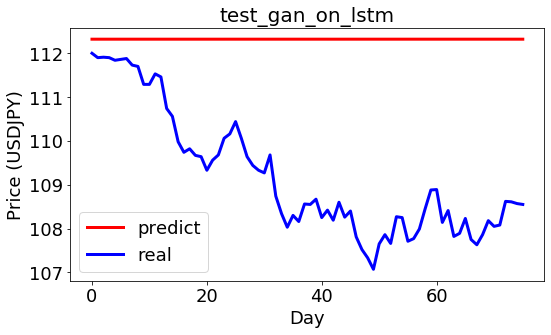

In [76]:
gan_onlstm_predictions, gan_onlstm_losses, gan_onlstm_generator = training(epochs, batch_size, "gan", "on_lstm")

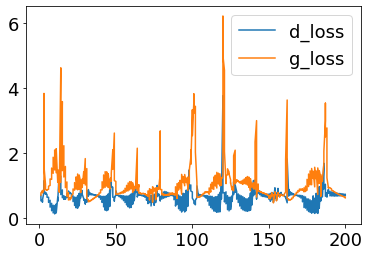

In [77]:
plt.plot(np.transpose(gan_onlstm_losses)[0], np.transpose(gan_onlstm_losses)[1], label='d_loss')
plt.plot(np.transpose(gan_onlstm_losses)[0], np.transpose(gan_onlstm_losses)[2], label='g_loss')
plt.legend()

# WGAN

In [43]:
# https://myurasov.github.io/2017/09/24/wasserstein-gan-keras.html

In [44]:
# # basically return mean(y_pred),
# # but with ability to inverse it for minimization (when y_true == -1)
# def wasserstein(y_true, y_pred):
#     return K.mean(y_true * y_pred, axis=-1)

In [45]:
# def create_wgan_discriminator():
#     discriminator=Sequential()
#     discriminator.add(Dense(units=512,input_dim=1))
#     discriminator.add(LeakyReLU(alpha=0.1))
#     discriminator.add(Dense(256))
#     discriminator.add(LeakyReLU(alpha=0.1))
#     discriminator.add(Dense(128))
#     discriminator.add(LeakyReLU(alpha=0.1))
#     discriminator.add(Dense(64))
#     discriminator.add(LeakyReLU(alpha=0.1))
#     discriminator.add(Dense(units=1, activation='sigmoid'))    
    
# #     discriminator.compile(loss=wasserstein, optimizer='adam')
#     discriminator.compile(loss=wasserstein, optimizer='RMSprop')
#     return discriminator
# d =create_discriminator()
# d.summary()

In [46]:
# epochs = 100
# wgan_predictions, wgan_losses, wgan_generator = training(epochs, batch_size, "wgan", "mlp")

In [47]:
# plt.plot(np.transpose(wgan_losses)[0], np.transpose(wgan_losses)[1], label='d_loss')
# plt.plot(np.transpose(wgan_losses)[0], np.transpose(wgan_losses)[2], label='g_loss')
# plt.legend()

# WGAN + LSTM

In [48]:
# epochs = 100
# wgan_lstm_predictions, wgan_lstm_losses, wgan_lstm_generator = training(epochs, batch_size, "wgan", "lstm")

In [49]:
# plt.plot(np.transpose(wgan_lstm_losses)[0], np.transpose(wgan_lstm_losses)[1], label='d_loss')
# plt.plot(np.transpose(wgan_lstm_losses)[0], np.transpose(wgan_lstm_losses)[2], label='g_loss')
# plt.legend()

# WGAN + ON-LSTM

In [50]:
# wgan_onlstm_predictions, wgan_onlstm_losses, wgan_onlstm_generator = training(epochs, batch_size, "wgan", "on_lstm")

In [51]:
# plt.plot(np.transpose(wgan_onlstm_losses)[0], np.transpose(wgan_onlstm_losses)[1], label='d_loss')
# plt.plot(np.transpose(wgan_onlstm_losses)[0], np.transpose(wgan_onlstm_losses)[2], label='g_loss')
# plt.legend()

# Compare performance

In [52]:
true = benchmark_actual_test
def accuracy_evaluation(method, true, prediction):
    # mean absolute error
    mae = mean_absolute_error(true, prediction)
    # mean absolute percentage error
    mape = np.mean(np.abs((true - prediction) / true)) * 100
    # root mean squared error
    rmse = np.sqrt(mean_squared_error(true, prediction))
    # mean squared error
    mse = mean_squared_error(true, prediction)
    # correlation coefficient
    corr = np.corrcoef(np.concatenate((np.transpose(true), np.transpose(prediction)), axis=0))[0,1]
    print ("{}:\tmae:{:.5}\tmape:{:.5}\trmse:{:.5}\tmse:{:.5}\tcorr:{:.3}".format(method, mae, mape, rmse, mse, corr))
    return

In [53]:
# accuracy_evaluation("arima\t", true, [list(x) for x in arima_predictions][1:])
accuracy_evaluation("lstm\t", true, lstm_predictions)
accuracy_evaluation("onlstm\t", true, on_lstm_predictions)
# accuracy_evaluation("gan_lstm", true, gan_lstm_predictions)
accuracy_evaluation("gan_onlstm", true, gan_onlstm_predictions)
# accuracy_evaluation("wgan_lstm", true, wgan_lstm_predictions)
# accuracy_evaluation("wgan_onlstm", true, wgan_onlstm_predictions)

lstm	:	mae:1.1053	mape:1.0136	rmse:1.2495	mse:1.5613	corr:0.96
onlstm	:	mae:1.4789	mape:1.358	rmse:1.6012	mse:2.5638	corr:0.946


# Trading

In [54]:
actual = benchmark_actual_test
on_lstm_predict = on_lstm_predictions[:,0]
lstm_predict = lstm_predictions[:,0]
print (actual.shape, on_lstm_predict.shape)

(76, 1) (76,)


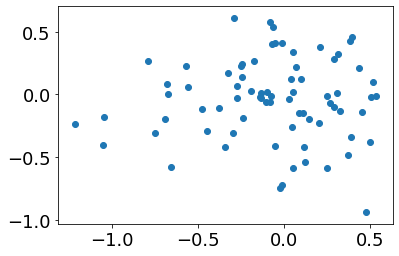

In [55]:
plt.scatter(np.diff(on_lstm_predict), np.diff(actual.T[0]))

In [56]:
y_true = np.where(np.diff(actual.T[0])>=0, 1, -1) 
y_pred = np.where(np.diff(on_lstm_predict)>=0, 1, -1) 
confusion_matrix(y_true, y_pred)

array([[21, 21],
       [20, 13]])

In [86]:
abs(np.diff(actual.T[0])).mean()

0.2534666666666675

In [87]:
def trading_profit(actual, predict, trading_type):
    tc = 0.0015
    profit = 0
    profit2 = 0
    trade_vol = 100000
    transaction_count = 0
    answer = 0
    answer2 = 0
    ans_increase = 0
    ans_decrease = 0
    increase = 0
    decrease = 0
    for i in range(len(actual)-1):
        # print (actual[i], actual[i+1], predict[i], predict[i+1]) 
        if predict[i] <= predict[i+1]:
            trade_diff = actual[i+1] - actual[i]
            transaction_count += 1
        else:
            if trading_type == 'buy_only':
                trade_diff = 0
            else:
                trade_diff = actual[i] - actual[i+1]
                transaction_count += 1
        answer += abs(actual[i+1] - actual[i]) * trade_vol
        answer2 += (abs(actual[i+1] - actual[i])-tc) * trade_vol
        if actual[i+1] - actual[i] >=0:
            ans_increase += 1
            if  predict[i+1] >= predict[i]:
                increase += 1
        else:
            ans_decrease += 1
            if  predict[i+1] < predict[i]:
                decrease += 1
        profit += trade_diff * trade_vol
        profit2 += (trade_diff-tc) * trade_vol
        #print (i, abs(actual[i+1] - actual[i]))
    print ("\n[ANSWER] max profit:{:}, {:}".format(answer, answer2))
    print ("trading_type: {}\t transaction_count: {}\t total_profit: {}\t profit/max_profit: {:.4}".format(
        trading_type, transaction_count, profit, float(profit/answer*100)))
    print ("trading_type2: {}\t transaction_count: {}\t total_profit2: {}\t profit2/max_profit2: {:.4}".format(
        trading_type, transaction_count, profit2, float(profit2/answer2*100)))
    print ("ans_increase:{}\tans_decrease:{}\tincrease:{}\tdecrease:{}\t{:}".format(
        ans_increase, ans_decrease, increase, decrease, (increase+decrease)/(ans_increase+ans_decrease)*100,))
    return profit

In [88]:
# print (len(arima_predictions), actual.shape)
# arima_predict1 = trading_profit(actual, arima_predictions[1:], 'buy_only')
# arima_predict2 = trading_profit(actual, arima_predictions[1:], 'buy_sell')

In [89]:
lstm_predict1 = trading_profit(actual, lstm_predict, 'buy_only')
lstm_predict2 = trading_profit(actual, lstm_predict, 'buy_sell')


[ANSWER] max profit:[1901000.00000001], [1889750.00000001]
trading_type: buy_only	 transaction_count: 31	 total_profit: [-474000.]	 profit/max_profit: -24.93
trading_type2: buy_only	 transaction_count: 31	 total_profit2: [-485250.]	 profit2/max_profit2: -25.68
ans_increase:33	ans_decrease:42	increase:10	decrease:21	41.333333333333336

[ANSWER] max profit:[1901000.00000001], [1889750.00000001]
trading_type: buy_sell	 transaction_count: 75	 total_profit: [-603000.00000001]	 profit/max_profit: -31.72
trading_type2: buy_sell	 transaction_count: 75	 total_profit2: [-614250.00000001]	 profit2/max_profit2: -32.5
ans_increase:33	ans_decrease:42	increase:10	decrease:21	41.333333333333336


In [90]:
on_lstm_predict1 = trading_profit(actual, on_lstm_predict, 'buy_only')
on_lstm_predict2 = trading_profit(actual, on_lstm_predict, 'buy_sell')


[ANSWER] max profit:[1901000.00000001], [1889750.00000001]
trading_type: buy_only	 transaction_count: 34	 total_profit: [-278000.]	 profit/max_profit: -14.62
trading_type2: buy_only	 transaction_count: 34	 total_profit2: [-289250.]	 profit2/max_profit2: -15.31
ans_increase:33	ans_decrease:42	increase:13	decrease:21	45.33333333333333

[ANSWER] max profit:[1901000.00000001], [1889750.00000001]
trading_type: buy_sell	 transaction_count: 75	 total_profit: [-211000.00000001]	 profit/max_profit: -11.1
trading_type2: buy_sell	 transaction_count: 75	 total_profit2: [-222250.00000001]	 profit2/max_profit2: -11.76
ans_increase:33	ans_decrease:42	increase:13	decrease:21	45.33333333333333


In [61]:
# gan_prediction1 = trading_profit(actual, gan_predictions, 'buy_only')
# gan_prediction2 = trading_profit(actual, gan_predictions, 'buy_sell')

In [62]:
# gan_lstm_predictions1 = trading_profit(actual, gan_lstm_predictions, 'buy_only')
# gan_lstm_predictions2 = trading_profit(actual, gan_lstm_predictions, 'buy_sell')

In [78]:
gan_onlstm_predictions1 = trading_profit(actual, gan_onlstm_predictions, 'buy_only')
gan_onlstm_predictions2 = trading_profit(actual, gan_onlstm_predictions, 'buy_sell')


[ANSWER] max profit:[1901000.00000001]
trading_type: buy_only	 transaction_count: 66	 total_profit: [-185000.]	 profit/max_profit: -9.732
ans_increase:33	ans_decrease:42	increase:31	decrease:7	50.66666666666667

[ANSWER] max profit:[1901000.00000001]
trading_type: buy_sell	 transaction_count: 75	 total_profit: [-25000.]	 profit/max_profit: -1.315
ans_increase:33	ans_decrease:42	increase:31	decrease:7	50.66666666666667


In [64]:
# wgan_prediction1 = trading_profit(actual, wgan_predictions, 'buy_only')
# wgan_prediction2 = trading_profit(actual, wgan_predictions, 'buy_sell')

In [65]:
# wgan_lstm_prediction1 = trading_profit(actual, wgan_lstm_predictions, 'buy_only')
# wgan_lstm_prediction2 = trading_profit(actual, wgan_lstm_predictions, 'buy_sell')

In [66]:
# wgan_onlstm_prediction1 = trading_profit(actual, wgan_onlstm_predictions, 'buy_only')
# wgan_onlstm_prediction2 = trading_profit(actual, wgan_onlstm_predictions, 'buy_sell')

# Check if the train data has been leaked 

In [67]:
print (test_features.shape)
print (test_features.shape[0])
print (len(test_features[0]))

(76, 60, 1)
76
60


In [68]:
test_features

array([[[0.35185185],
        [0.36752137],
        [0.3988604 ],
        ...,
        [0.68660969],
        [0.69088319],
        [0.68376068]],

       [[0.36752137],
        [0.3988604 ],
        [0.32621083],
        ...,
        [0.69088319],
        [0.68376068],
        [0.7022792 ]],

       [[0.3988604 ],
        [0.32621083],
        [0.31766382],
        ...,
        [0.68376068],
        [0.7022792 ],
        [0.68803419]],

       ...,

       [[0.52279202],
        [0.497151  ],
        [0.41452991],
        ...,
        [0.13960114],
        [0.14387464],
        [0.22079772]],

       [[0.497151  ],
        [0.41452991],
        [0.38034188],
        ...,
        [0.14387464],
        [0.22079772],
        [0.21937322]],

       [[0.41452991],
        [0.38034188],
        [0.39173789],
        ...,
        [0.22079772],
        [0.21937322],
        [0.21367521]]])

In [69]:
test_features[0][:3]

array([[0.35185185],
       [0.36752137],
       [0.3988604 ]])

In [70]:
test_features[0][lstm_batch_size-3:]

array([[0.68660969],
       [0.69088319],
       [0.68376068]])

In [71]:
test_features[1][:3]

array([[0.36752137],
       [0.3988604 ],
       [0.32621083]])

In [72]:
gan_onlstm_generator.predict(test_features[0:1,:,:])

array([[0.5216684]], dtype=float32)

In [73]:
gan_onlstm_generator.predict(test_features[1:2,:,:])

array([[0.5216757]], dtype=float32)

In [74]:
generated_timeseries_predict_test = gan_onlstm_generator.predict(test_features)
plot_timeseries(0, "check1", "gan", "onlstm", generated_timeseries_predict_test[0:3], df_test.iloc[:, 1:2].values[0:3])            

test_predictions = scaler_train_output.inverse_transform(generated_timeseries_predict_test)
plot_timeseries(0, "check2", "gan", "onlstm", test_predictions[0:3], df_test.iloc[:, 1:2].values[0:3])            

NameError: name 'df_test' is not defined

In [ ]:
test_features[:,1:2,:].T[0][0]

In [ ]:
test_features

In [ ]:
np.diff(scaler_train_output.inverse_transform(test_features[:,0:1,:].T[0]))[0]

In [ ]:
np.diff(actual)

In [ ]:
on_lstm_predictions